# Getting Started With Dataset

You are reading this text and want to go deeper into the Dataset Library, it can only mean one thing - you are some next level explorers! This notebook introduces you to the basic features of the Dataset Library by writing  simple regression models.

Some useful files that we will use in this tutorial:
* [myfirstbatch](./../utils/myfirstbatch.py)
* [data_generator](./../utils/data_generator.py)
* [basic regression models](./../utils/models.py).

In [1]:
import sys

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('..')
sys.path.append('../utils')

from myfirstbatch import MyBatch
from models import Regressions
from data_generator import generate_linear_data, \
                           generate_logistic_data, \
                           generate_poisson_data
from dataset import Dataset, DatasetIndex, V, F, B

/home/anton/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Linear regression
First, we consider linear regression that allows solving tasks where targets are continuous variables.
For this reason we generate data from uniform or normal distributions, multiply it by normally distributed weights and add normally distributed noise and then try to predict it. 

In this case, <i>linear_x and linear_y</i> are two numpy arrays. Data is a matrix with __size__ rows and 13 cols. Prediction value is numpy array with len equal __size__.

In [2]:
size = 1000
linear_x, linear_y = generate_linear_data(size=size)

Now it's time to create Dataset (the instance of Dataset class) with our class named __MyBatch__ and split it into train/test. Dataset is needed to create batches in future, but now the Dataset is empty until we load the data into it. First of all, we create __Index__ for our Dataset. The __Index__ holds the sequence of data items' indices. This mechanism is needed to uniquely address each data item. You can read more about [using](https://analysiscenter.github.io/dataset/intro/intro.html) Dataset, Dataset [itself](https://analysiscenter.github.io/dataset/intro/dataset.html), and [Index](https://analysiscenter.github.io/dataset/intro/index.html).

In [3]:
ind = DatasetIndex(np.arange(size))
linear_dset = Dataset(ind, batch_class=MyBatch)
linear_dset.cv_split()

After creating a Dataset you can load data into it with [pipeline](https://analysiscenter.github.io/dataset/intro/pipeline.html) which allows you to use and perform functions from the [batch class](https://analysiscenter.github.io/dataset/intro/batch.html). As for example __load__ from [myfirstbatch](./../utils/myfirstbatch.py) in the cell below.

In [4]:
pipeline = (linear_dset.train.p
                       .load((linear_x, linear_y)))

The pipeline defined above only loads data. Clearly, it doesn't train linear regression, therefore it is not enough for us.
But before talking about "How to train linear regression?" let's talk about "What do we generally train?".

All possible algorithms that can be trained in Dataset are named models. In our case, they are based on tensorflow. Hence, first of all, we need to create a model with linear regression. It is shown in the [model file](./../utils/models.py) file. How to create your own model you can read in [docs](https://analysiscenter.github.io/dataset/intro/tf_models#how-to-write-a-custom-model).

After the model is ready, you need to train it. The pipeline allows you to do this with just two functions:
* [__init_model__](https://analysiscenter.github.io/dataset/intro/models.html#adding-a-model-to-a-pipeline) - function allows to initialize our model. About arguments you can read in [API](https://analysiscenter.github.io/dataset/api/dataset.pipeline.html?highlight=init_model#dataset.Pipeline.init_model)
* [__train_model__](https://analysiscenter.github.io/dataset/intro/models.html#training-a-model) - function allows train our model. [API](https://analysiscenter.github.io/dataset/api/dataset.pipeline.html?highlight=train_model#dataset.Pipeline.train_model).

This functions can be configured and below we consider a configuration in details.

The first function for us to start is the __init_model__. Our config will consist of two parts. Part one - __inputs_config__ which consists of parameters for input tensors. 
As you know, to train a tensorflow model you have to create placeholders for input data, but if you open [model file](./../utils/models.py) you won't find them because they are created inside __inputs_config__. You can control this by using 'inputs' key in __config__ about which the story is told further.

To configure 'inputs' use the __inputs_config__ dict shown in the cell below. This dict has two keys:
* __input__ - the name of the placeholder for the input data.
* __labels__ - the name of the placeholder for the answers before all transformations.

Values for these keys are dicts themselves with the following parameters:
* __shape__ - the shape of the created placeholder, or in other words, the shape of the input(output) of the model.
* __name__ - the name of the placeholder after transformations.

For more information see [docs](https://analysiscenter.github.io/dataset/intro/tf_models#how-to-configure-a-model) and [API](https://analysiscenter.github.io/dataset/api/dataset.models.tf.base.html#dataset.models.tf.TFModel._make_inputs).

In [5]:
inputs_config = {
    'input': {'shape': (13)},
    'labels': {'shape': (1),
               'name': 'targets'}
}

Part two it is the rest of the parameters, which is needed to control our model. Like loss function or optimizer.
This occurs in the __config__ of the model. It looks like that:

In [6]:
config={
    'inputs': inputs_config,
    'loss': 'mse',
    'optimizer': {'name':'GradientDescentOptimizer',
                  'learning_rate': 0.01},
    'input_block/inputs': 'input',
    'body/units': 1
}

config keys:
* __inputs__ - described above.
* __optimizer__ - dict with optimizer and parameters for it.
* __loss__ - a loss for our model, can be dict with parameters too.
* __input_block/inputs__ - the name of tensor which is an input of input block.
* __body/units__ - number of filters on fully-connected layer. Can be a _list_, if you have more than one dense layer. In our case, there is one output filter.

<img src='./../pictures/dataset_structure.png' width="600" height="600"/>


As you can see, the last two keys have a hierarchical structure that configure one part of the model. In general, the models consist of thee blocks and the output block in the end. Each of key with hierarchical structure contains parameters for own part of the model.

The documentation, can tell you more about the [overall configuration](https://analysiscenter.github.io/dataset/intro/tf_models#getting-started) and [model configration](https://analysiscenter.github.io/dataset/intro/models#configuring-a-model).

__train_model__ does not need same configuration, as the __init_model__. It just has feed dict with names of placeholders and data, which are loaded into it, as in tensorflow sessions. If you need to get some information during training such as loss or something else, see how it works in function __predict_model__ which you can find below.

In [7]:
data_dict = {
    'input': B('input'),
    'labels': B('labels')
}

__data_dict__, like __feed_dict__ from tensorflow, is a dict in which:
* _key_ is a name of placeholder
* _value_ is a input data for placeholder.

Letter B in _values_ is a [named expression](https://analysiscenter.github.io/dataset/intro/named_expr.html) which shows, that name inside is the batch class attribute or component name.

In this case, it is the [component](https://analysiscenter.github.io/dataset/intro/batch.html#components) name. You can see it in [batch](./../utils/myfirstbatch.py) class of our model. Therefore, placeholder takes data from the component.  

At the moment we have the pipeline, which can generate batch indices and upload batch data to it. Also we defined configuration dictionaries for our model. Now the time has come to train it using known functions: __init_model__ and __train_model__. Remember that previously we have created the pipeline with load method, let's add into it __init_model__ and __train_model__. Read more about pipeline arithmetic in [docs](https://analysiscenter.github.io/dataset/intro/pipeline.html#algebra-of-pipelines).

In [8]:
BATCH_SIZE = 100
train_linear = ((pipeline << linear_dset.train)
                .init_model('dynamic',
                            Regressions,
                            'linear',
                            config=config)
                .train_model('linear',
                             feed_dict=data_dict)
                .run(BATCH_SIZE, shuffle=True, n_epochs=100))

Pipeline to predict test data would be also helpful. For this purpose the function [__predict_model__](https://analysiscenter.github.io/dataset/intro/models.html#predicting-with-a-model) is used. 

I would direct your attention to the argument named __fetches__.
It returns a value of tensor with a specified name. Using it, you can always get from model any tensor you want and don't forget to write the name of class before it.

<img src='./../pictures/fetches.png' width="600" height="600"/>
As you already know, in __ouptut__ parameter you can specify a list with useful outputs, such as 'labels', 'accuracy', etc. (if you don't know about it, read [this](https://analysiscenter.github.io/dataset/intro/tf_models#output)). __fetches__ allows you to get this outputs from model by adding 'output_' before the name, for example if you want to get the accuracy, you need to configurate __fetches__ in this way ```fetches='output_accuracy'```.

Another important point is function [__import_model__](https://analysiscenter.github.io/dataset/intro/models.html#importing-models), that loads model from another pipeline.

In [9]:
BATCH_SIZE = 1
test_linear = (((pipeline << linear_dset.test)
                 .import_model('linear', train_linear)
                 .init_variable('predict', init_on_each_run=list)
                 .predict_model('linear', 
                                fetches='predictions',
                                feed_dict=data_dict,
                                save_to=V('predict'), mode='a'))
                 .run(BATCH_SIZE, shuffle=False, n_epochs=1))

In the last __pipeline__, we test our model. Let's see, how well does it work?

In [10]:
predict = np.array(test_linear.get_variable('predict')).reshape(-1)
target = np.array(linear_y[linear_dset.test.indices]).reshape(-1)

percent = np.mean(np.abs((target - predict) * 100 / target))

print('Percentage of errors: {}%'.format(round(percent, 3)))

Percentage of errors: 0.856%


# Logistic regression 
It solves a task with a binary target (0 or 1, -1 or 1 and etc).

To train our logistic regression we enerate a two-dimensional data (with points) from two linearly separeted clusters and fit the logistic regression to predict number of the cluster.

In [11]:
size = 500
logistic_x, logistic_y = generate_logistic_data(size, [[1,2],[[15,0],[0,15]]], [[10,17],[[15,0],[0,15]]])

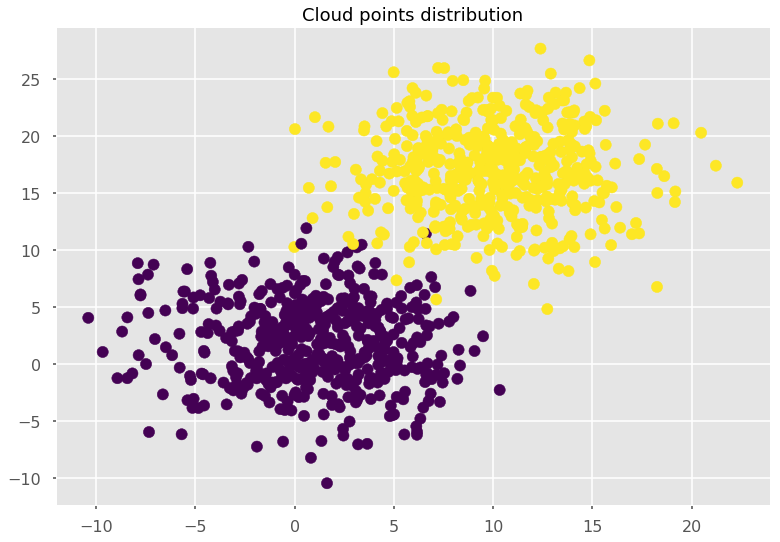

In [12]:
plt.style.use('seaborn-poster')
plt.style.use('ggplot')
plt.scatter(logistic_x[:,0], logistic_x[:,1], c=logistic_y)
plt.title('Cloud points distribution', fontsize=18)
plt.show()

One of the most important things that you need to know is that it really doesn't matter, which model you want to train and what data you will use for it. The interface is always the same. Let's see.

First of all, as in the previous time, Dataset is created and split. The only difference is in the preloaded data and the size of the dataset. 

In [13]:
logistic_dset = Dataset(np.arange(size), batch_class=MyBatch)
logistic_dset.cv_split()

As you can see, the structure of pipeline is almost the same. In __inputs_config__ __shape__ has changed from 13 to 2 because now we have two dimensional data. In labels new parameters appeared:
* __classes__ - the number of classes. We have a binary classification, hence 2 classes. 
* __transform__ - type of transformation of labels. We use one hot encoding or 'ohe'.

In [14]:
inputs_config = {
    'input': {'shape': (2)},
    'labels': {'classes': 2,
               'transform': 'ohe',
               'name': 'targets'}
}

Create and instantly execute our pipeline by using the __run__ function

In [15]:
BATCH_SIZE=10
train_logistic = (logistic_dset.train.p
                .load((logistic_x, logistic_y))
                .init_variable('current_loss', init_on_each_run=list)
                .init_model('dynamic',
                            Regressions,
                            'logistic',
                            config={
                                'inputs': inputs_config,
                                'loss': 'ce',
                                'optimizer': {'name':'Adam', 
                                              'learning_rate':0.01},
                                'input_block/inputs': 'input',
                                'body/units': 2,
                                'output': dict(ops=['labels', 'accuracy'])})
                .train_model('logistic',
                             fetches='loss',
                             feed_dict={
                                 'input': B('input'),
                                 'labels': B('labels')},
                            save_to=V('current_loss'), mode='a', use_lock=True)
                .run(BATCH_SIZE, shuffle=True, n_epochs=10))

In the same way, create test pipeline and run it too

In [16]:
BATCH_SIZE = 1
test_logistic = (logistic_dset.test.p
                .import_model('logistic', train_logistic)
                .load((logistic_x, logistic_y))
                .init_variable('probability', init_on_each_run=list)
                .predict_model('logistic', 
                             fetches='output_accuracy' ,
                             feed_dict={
                                 'input': B('input'),
                                 'labels': B('labels')},
                             save_to=V('probability'), mode='a')
                .run(BATCH_SIZE, shuffle=False, n_epochs=1))

After measure the quality of training

In [17]:
prob = np.array(test_logistic.get_variable('probability')).reshape(-1)
percentage = np.mean(prob)
print('Percentage of true values: {:.2%}'.format(percentage))

Percentage of true values: 100.00%


# Poisson regression 
Poisson regression is being used if the answer is count. 

The example shows how we can train poisson regression by using data generated from poisson distribution.

In [18]:
size = 1000
NUM_DIM = 13
poisson_x, poisson_y = generate_poisson_data(np.random.random(NUM_DIM), size)

Below you can see the same cell as previously, but with different names of models

In [19]:
poisson_dset = Dataset(np.arange(size), batch_class=MyBatch)
poisson_dset.cv_split()

We can create our own loss function and use it to train the model

In [20]:
def loss_poisson(target, predictions):
    return tf.reduce_mean(tf.nn.log_poisson_loss(target, predictions))

Again __shape__ equal 13, as the shape of the data

In [21]:
inputs_config = {
    'input': {'shape': (13)},
    'labels': {'shape': (1),
               'name': 'targets'}
}

Create and train pipeline

In [22]:
BATCH_SIZE=100
train_poisson = (poisson_dset.train.p
                .load((poisson_x, poisson_y))
                .init_variable('shape')
                .init_model('dynamic', 
                            Regressions, 
                            'poisson',
                            config={
                                'inputs': inputs_config,
                                'loss': loss_poisson,
                                'optimizer': {'name': 'Adam', 
                                              'learning_rate': 0.02},
                                'input_block/inputs': 'input',
                                'body/units': 1,
                                'output': dict(ops=['labels'])})
                .train_model('poisson',
                             fetches='loss',
                             feed_dict={
                                 'input': B('input'),
                                 'labels': B('labels')})
                .run(BATCH_SIZE, shuffle=True, n_epochs=150))

Create test pipeline and make predictions

In [23]:
test_poisson = ((poisson_dset.test.p
                .load((poisson_x, poisson_y))
                .import_model('poisson', train_poisson)
                .init_variable('all_predictions', init_on_each_run=list)
                .init_variable('answers', init_on_each_run=list)
                .predict_model('poisson', 
                               fetches=['Regressions/predicted_poisson', 'labels'],
                               feed_dict={
                                   'input': B('input'),
                                   'labels': B('labels')},
                               save_to=[V('all_predictions'), V('answers')], mode='a'))
                .run(BATCH_SIZE, shuffle=True, n_epochs=1))

Measure the quality

In [24]:
pred = np.array(test_poisson.get_variable('all_predictions')).reshape(-1)
target = np.array(test_poisson.get_variable('answers')).reshape(-1)


true_var = np.mean((target - np.mean(target))**2)
predict_var = np.mean((pred - np.mean(pred))**2)

percent = np.mean(np.abs(pred - target))/np.mean(target)*100
print('Percentage of errors: {}%'.format(round(percent, 3)), 'Variance ratio: %.3f' % (predict_var / true_var))

Percentage of errors: 9.228% Variance ratio: 1.046


### Conclusion
* No matter what you want to train and what data you want to use for it, pipeline always looks the same.
* Now you know how to use the Dataset:
    * create pipelines for train and test models
    * train linear regression with 13-dimensions data
    * train logistic regression (with another type of data - two-dimensions clouds of dots)
    * create your own loss function and train poisson regression.

### What's next?
After reading this notebook you may be wondering what to do next. I have ideas for you:
* create a multi-class regression model
* add aditional features to the model in order to improve the quality
* train your model and tell us about your achievement:)

If you have not looked at the [batch operations](./02_batch_operations.ipynb), it's time to do it!

If you want to return to the table of contents click [here](./00_description.ipynb).